# CNN for Classification

In this notebook, we define and train a CNN to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist). 

We will not give this model any weights as we did in the last notebook. Instead of pre-defining filters and weights for a convolutional neural network, we are just going to define the structure of a CNN model then train it on the provided training images until the model **learns and generates filter weights on its own**!

About the data:
* 28x28 grayscales images
* Each comes with a label 0-9, indicating the clothing class
* 60,000 training images and 10,000 testing images

<img src='images/training_data.png' height=40% width=40% />

### Load the [data](http://pytorch.org/docs/master/torchvision/datasets.html)

In this cell, we load in both **training and test** datasets from the FashionMNIST class.

In [1]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [2]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

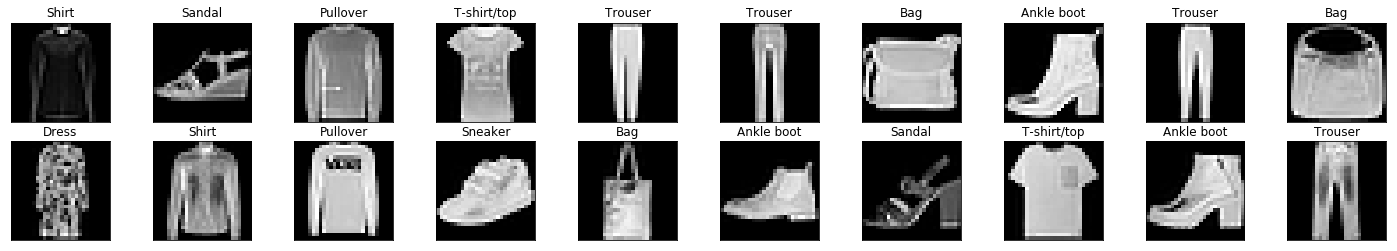

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

---
## Define the network architecture

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/master/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

<img src='images/2_layer_labeled_model.png' height=70% width=70% />


To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

You must place any layers with trainable weights, such as convolutional layers, in the `__init__` function and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, may appear *only* in the `forward` function. In practice, you'll often see conv/pool layers defined in `__init__` and activations defined in `forward`.

#### Convolutional layer
The first convolution layer has been defined for you, it takes in a 1 channel (grayscale) image and outputs 10 feature maps as output, after convolving the image with 3x3 filters.

#### Flattening

Recall that to move from the output of a convolutional/pooling layer to a linear layer, you must first flatten your extracted features into a vector. If you've used the deep learning library, Keras, you may have seen this done by `Flatten()`, and in PyTorch you can flatten an input `x` with `x = x.view(x.size(0), -1)`.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## Define a convolutional layer
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        filters_1 = 10
        self.conv1 = nn.Conv2d(1, filters_1, 3)
        
        # a pooling layer that reduces the size of the image by 2
        self.pool1 = nn.MaxPool2d(2,2)
        
        # a second convolutional layer that increases the number of filtered outputs
        filters_2 = 20
        self.conv2 = nn.Conv2d(filters_1, filters_2, 3)

        # another pooling layer
        self.pool2 = nn.MaxPool2d(2,2)
        
        # finally, a full-connected linear layer
        # Why is this filers_2*5*5? 
        # check the image above to see how the shape of the input changes as it moved through this model
        n_classes = 10
        self.fc1 = nn.Linear(filters_2*5*5, n_classes)
        

    ## Define the forward behavior
    def forward(self, x):
        # both conv/pool layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # flatten the output of the final pooling layer
        # pass it as input to the fully-connected layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        # final output
        return x

# create and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


###  Specify the loss function and optimizer

Learn more about [loss functions](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizers](http://pytorch.org/docs/stable/optim.html) in the online documentation.

Note that for a classification problem like this, one typically uses cross entropy loss, which can be defined in code like: `loss_function = nn.CrossEntropyLoss()`. PyTorch also includes some standard stochastic optimizers like stochastic gradient descent and Adam. You're encouraged to try different optimizers and see how your model responds to these choices as it trains.

#### Learning Rate

The learning rate, `lr`, in our optimizer defines how much this model will update the weights when it detects an error. A larger learning rate will make bigger changes (and fix errors more quickly) but a smaller learning rate should find the best weights within a smaller range. This is often the first parameter I try to set when I start training. It is usually a velua between 0.001 and 0.01.


In [5]:
import torch.optim as optim

## Specify loss function (try categorical cross-entropy)
loss_function = nn.CrossEntropyLoss()

## Specify optimizer (I'm using stochastic gradient descent)
optimizer = optim.SGD(net.parameters(), lr=0.01)

### A note on accuracy

It's interesting to look at the accuracy of your network **before and after** training. This way you can really see that your network has learned something. In the next cell, let's see what the accuracy of an untrained network is (we expect it to be around 10% which is the same accuracy as just guessing for all 10 classes).

In [6]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
accuracy = 100 * correct / total

# print it out!
print('Accuracy before training: ', accuracy.item())

Accuracy before training:  8


### Train the Network

Below, we've defined a `train` function that takes in a number of epochs to train for. The number of epochs is how many times a network will cycle through the training dataset. 

Here are the steps that this training function performs as it iterates over the training dataset:

1. Zero's the gradients to prepare for a forward pass
2. Passes the input through the network (forward pass)
3. Computes the loss (how far is the predicted classes are from the correct labels)
4. Propagates gradients back into the network’s parameters (backward pass)
5. Updates the weights (parameter update)
6. Prints out the calculated loss



In [7]:
def train(n_epochs):
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data       

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = loss_function(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            if batch_i % 1000 == 999:    # print every 1000 mini-batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [8]:
# define the number of epochs to train for
n_epochs = 5 # start small to see if your model works, initially

# call train
train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.2288419450223447
Epoch: 1, Batch: 2000, Avg. Loss: 0.6937933005094529
Epoch: 1, Batch: 3000, Avg. Loss: 0.5920797569081188
Epoch: 2, Batch: 1000, Avg. Loss: 0.5322626407891512
Epoch: 2, Batch: 2000, Avg. Loss: 0.5146656086966396
Epoch: 2, Batch: 3000, Avg. Loss: 0.4933703503347933
Epoch: 3, Batch: 1000, Avg. Loss: 0.47358307205140593
Epoch: 3, Batch: 2000, Avg. Loss: 0.44969217107445003
Epoch: 3, Batch: 3000, Avg. Loss: 0.4456645141467452
Epoch: 4, Batch: 1000, Avg. Loss: 0.42868348659574984
Epoch: 4, Batch: 2000, Avg. Loss: 0.41917451394349337
Epoch: 4, Batch: 3000, Avg. Loss: 0.42407298716157676
Epoch: 5, Batch: 1000, Avg. Loss: 0.4059670155346394
Epoch: 5, Batch: 2000, Avg. Loss: 0.40310325153172016
Epoch: 5, Batch: 3000, Avg. Loss: 0.40133672138676046
Finished Training


### Test the Trained Network

Once you are satisfied with how the loss of your model has decreased, there is one last step: test!

You must test your trained model on a previously unseen dataset to see if it generalizes well and can accurately classify this new dataset. For FashionMNIST, which contains many pre-processed training images, a good model should reach **greater than 85% accuracy** on this test dataset. If you are not reaching this value, try training for a larger number of epochs, tweaking your hyperparameters, or adding/subtracting layers from your CNN.

In [9]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = loss_function(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.434078

Test Accuracy of T-shirt/top: 66% (667/1000)
Test Accuracy of Trouser: 96% (968/1000)
Test Accuracy of Pullover: 83% (833/1000)
Test Accuracy of Dress: 87% (874/1000)
Test Accuracy of  Coat: 62% (626/1000)
Test Accuracy of Sandal: 93% (935/1000)
Test Accuracy of Shirt: 69% (692/1000)
Test Accuracy of Sneaker: 96% (969/1000)
Test Accuracy of   Bag: 93% (939/1000)
Test Accuracy of Ankle boot: 92% (926/1000)

Test Accuracy (Overall): 84% (8429/10000)


### Visualize sample test results

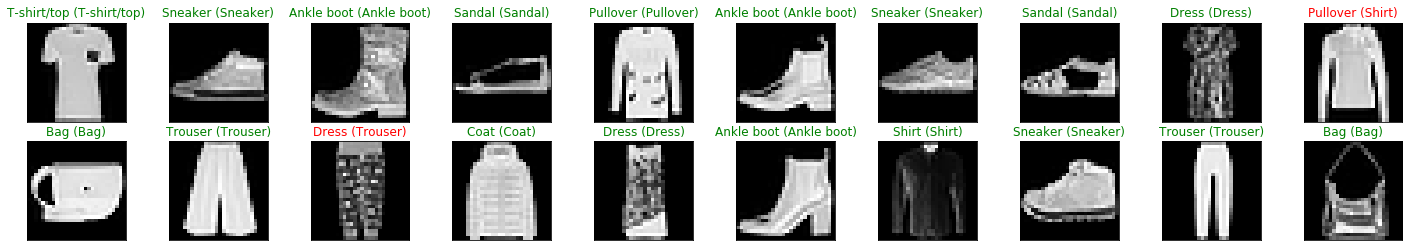

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Question: What are some weaknesses of your model? (And how might you improve these in future iterations.)

**Answer**: It doesn't classify coats or shirts very well, I suspect this is becase the structure of these two items of clothing is kind of similar (like the sleeves). This model may too simple or may be overfitting other classes at the cost of these two. So, if I had more time to train, I'd probably add one more convolutional layer, train for a longer time, and/or add a dropout layer to avoid overfitting.

### Save Your Best Model

Once you've decided on a network architecture and are satisfied with the test accuracy of your model after training, it's time to save this so that you can refer back to this model, and use it at a later data for comparison of for another classification task!

In [11]:
## TODO: change the model_name to something uniqe for any new model
## you wish to save, this will save it in the saved_models directory
model_dir = 'saved_models/'
model_name = 'model_simple.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)

---
## Load a Trained, Saved Model

After you've trained a couple models and want to select the best one, you can load it by name (you'll also have to define the architecture in this notebook in `Net`.

To instantiate a trained model, you'll first instantiate a new `Net()` and then initialize it with a saved dictionary of parameters, which our the learned weights of the model.

In [12]:
# instantiate your Net
# this refers to your Net class defined above
net = Net()

# load the net parameters by name
# uncomment and write the name of a saved model
net.load_state_dict(torch.load('saved_models/model_simple.pt'))

print(net)

# Once you've loaded a specific model in, you can then 
# us it or further analyze it! 
# This will be especialy useful for feature visualization 

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


---
# Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. These techniques are called feature visualization and they are useful for understanding the inner workings of a CNN.

In the cell below, you'll see how to extract and visualize the filter weights for all of the filters in the first convolutional layer.

Note the patterns of light and dark pixels and see if you can tell what a particular filter is detecting. For example, the filter pictured in the example below has dark pixels on either side and light pixels in the middle column, and so it may be detecting vertical edges.

<img src='images/edge_filter_ex.png' width= 30% height=30%/>



First convolutional layer


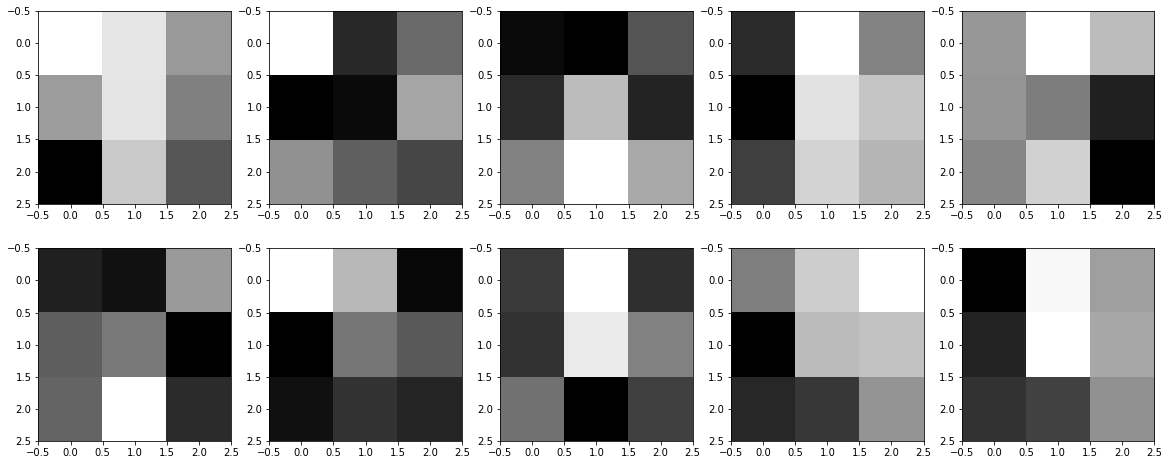

In [13]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data
w = weights.numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.numpy()

### Filtered Outputs

Next, you'll see how to use OpenCV's `filter2D` function to apply these filters to a sample test image and produce a series of **filtered outputs** as a result. We'll do this for the first and second convolutional layers and these outputs should really give you a sense for what features each filter has learned to extract.

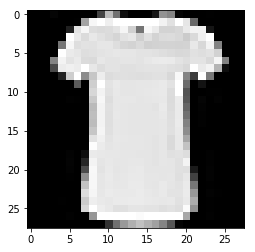

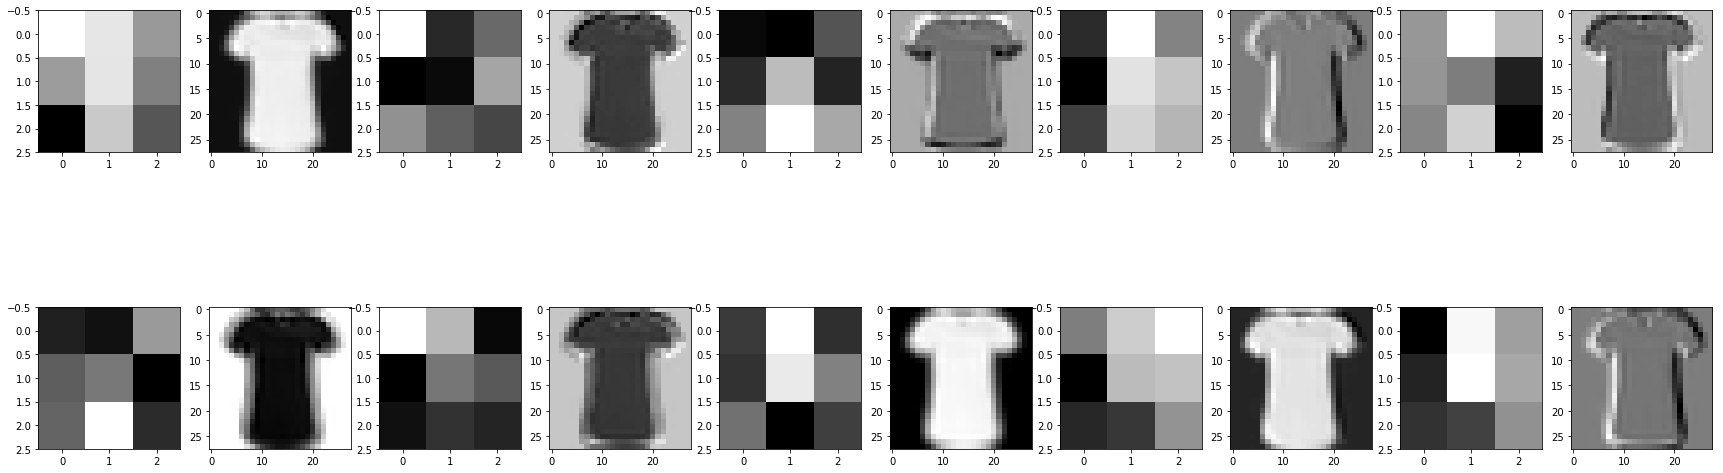

In [14]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 10
img = np.squeeze(images[idx])

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = net.conv1.weight.data
w = weights.numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

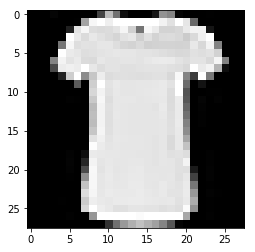

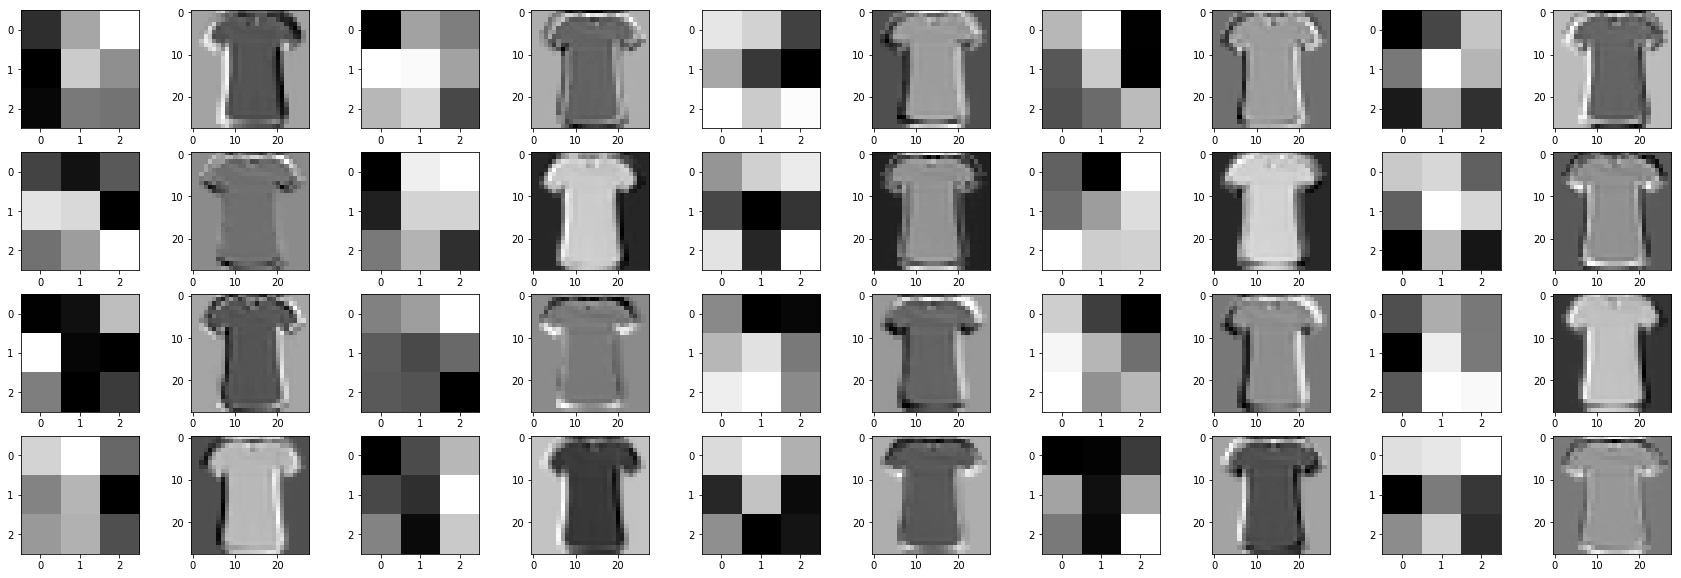

In [15]:
# Same process but for the second conv layer (20, 3x3 filters):
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = net.conv2.weight.data
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2*2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question: Choose a filter from one of your trained convolutional layers; looking at these activations, what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: In the first convolutional layer (conv1), the very last filter, pictured as the last filter in the second row of the conv1 filters, appears to detect vertical/slightly-left leaning edges. It has a positively weighted middle and right-most column and seems to detect the vertical edges of sleeves on a shirt.